<a href="https://colab.research.google.com/github/denisakatov/deep_comp_vision/blob/main/deep_vision_hm_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]**

## Переключение версии TensorFlow

In [34]:
%tensorflow_version 2.x

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета lfw

In [36]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

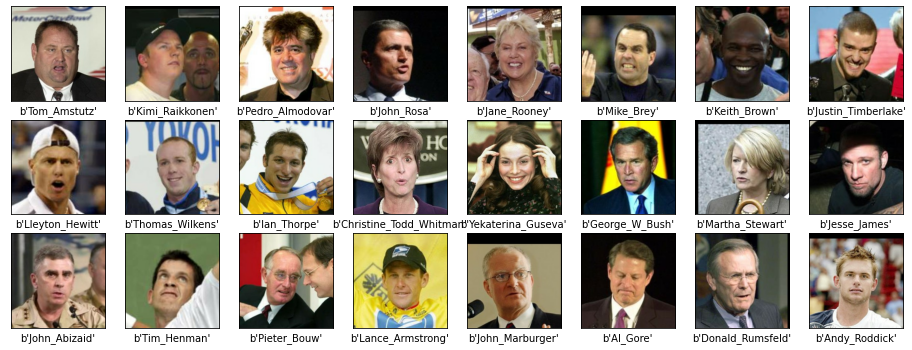

In [37]:
ds = train_ds.take(24)

fig = plt.figure(figsize=(16, 8))
j = 0
for label, image in tfds.as_numpy(ds):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(str(label))
    j += 1
plt.show()

## Создание модели CNN

In [38]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [39]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [40]:
INP_SIZE = 250
NUM_EPOCHS = 6
BATCH_SIZE = 32

def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=len(test_ds))
test_ds = test_ds.map(prepare)
test_ds = test_ds.repeat(NUM_EPOCHS)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

## Подготовка к обучению

In [14]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [46]:
for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 88.10750579833984
[200] Loss: 0.0
[400] Loss: 0.0
[600] Loss: 0.0
[800] Loss: 0.0038977607619017363
[1000] Loss: 0.03892962262034416
[1200] Loss: 0.0
[1400] Loss: 0.0
[1600] Loss: 0.5564915537834167
[1800] Loss: 0.039054758846759796
[2000] Loss: 0.19907890260219574
[2200] Loss: 0.0


## Функция для визуализации эмбеддингов

In [17]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация образцов в 2D пространстве с помощью TSNE

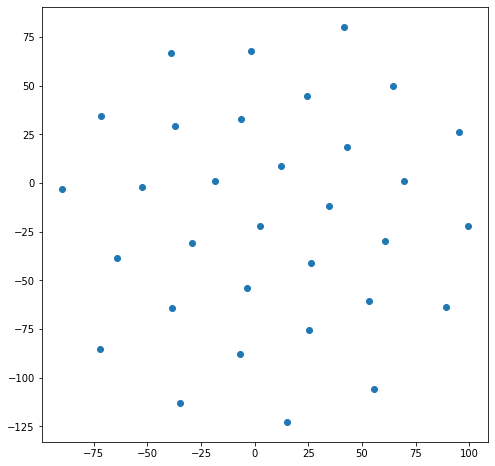

In [42]:
ds = test_ds.take(1)

fig = plt.figure(figsize=(8, 8))

for images, labels in tfds.as_numpy(ds):
    test_embs = model(images)
    # print(labels)
    test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
    plt.scatter(test_embs_2D[:,0], test_embs_2D[:,1])
plt.show()